# Курс "Программирование на языке Python. Уровень 4. Анализ и визуализация данных на языке Python. Библиотеки numpy, pandas, matplotlib"

## Модуль 9. Временные ряды в pandas

1. Работа с датами в Python
2. Объект TimeSeries в Pandas - особенности, срезы и пр.
4. Частоты и периоды, ресемплинг, сдвиг
5. Статистический анализ временных рядов: "скользящее окно" и STL-декомпозиция

Для работы загрузите в директорию ```data``` следующие данные (их можно загрузить прямо отсюда, через "Сохранить как..."):
- [data/macrodata.csv](https://github.com/easyise/spec_python_courses/raw/master/python04-analysis/data/macrodata.csv)
- [data/web_traffic.tsv](https://github.com/easyise/spec_python_courses/raw/master/python04-analysis/data/web_traffic.tsv)
- [data/monthly-temperature-in-celsius-j.csv](https://github.com/easyise/spec_python_courses/raw/master/python04-analysis/data/monthly-temperature-in-celsius-j.csv)
- [data/monthly-australian-wine-sales.csv](https://github.com/easyise/spec_python_courses/raw/master/python04-analysis/data/monthly-australian-wine-sales.csv)


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from datetime import date
from datetime import timedelta

import statsmodels.api as sm

plt.rcParams['figure.figsize'] = (10.0, 10.0)
%matplotlib inline


### Дата и время в Python

Модуль для работы с датами - ```datetime```.

В нем следующие классы:
- datetime.date
- datetime.timedelta
- datetime.datetime

При работе ориентируемся на ISO-стандарт хранения даты и времени в виде текстовой строки: \
```YYYY-MM-DD HH:MM:SS.mmm```.

Этот старндарт используется в SQL, JavaScript и других языках программирования, принимается множеством API.

Для создания даты из такой строки используйте метод ```datetime.fromisoformat()```.
Сохранить дату в ISO-формате: ```datetime.isoformat()```.

Текущее местное время: ```datetime.today()```. Время по UTC: ```datetime.utcnow()```

**ВНИМАНИЕ!** Смещение часового пояса относительно UTC используйте только если вы действительно работаете с данными в разных часовых поясах. Если это не требуется (и не может портребоваться в перспективе) - не используйте этот параметр.

In [2]:
now = datetime.today()
print(now.timestamp())
print(now.isoformat())

unixEpoch = datetime.fromisoformat("1970-01-01 03:00")
print(unixEpoch.isoformat())

# то же самое - с датами
today = date.today()
print(today.isoformat())

# Можно создать дату, зная месяц, год и число:
gagarin_date = date(1961, 4, 12)
print(gagarin_date)

1639064963.955907
2021-12-09T18:49:23.955907
1970-01-01T03:00:00
2021-12-09
1961-04-12


Преобразование дат в строку: ```datetime.strftime()```

Пример преобразования в строку в соответствии с ISO-форматом:
```somedate.strftime('%Y-%m-%d %H:%M:%S')```

#### ЗАДАНИЕ. Преобразуйте сегодняшнюю дату в формат ДД.ММ.ГГГГ ЧЧ:ММ

In [47]:
now.strftime('%d.%m.%Y %H:%M')


'09.12.2021 19:22'

#### Разница во времени, временные интервалы

Используем класс ```timedelta```. "Дельты" можно складывать с датами и датой/временем, друг с другом, делить, умножать и так далее.

In [11]:
delta = timedelta(
    days=50,\
    seconds=27,\
    microseconds=10,\
    milliseconds=29000,\
    minutes=5,\
    hours=8,\
    weeks=2\
)

now_plus_delta = now + delta
print(now_plus_delta.isoformat())

mins_15 = timedelta(minutes = 15) 

now_plus_half_hour = datetime.today() + mins_15*2
print(now_plus_half_hour)

print(now_plus_delta > now_plus_half_hour)

2022-02-12T02:55:19.955917
2021-12-09 19:28:21.238763
True


#### ПРАКТИКА

1. Создайте массив numpy из 10 дат, которые соответствуют текущей и далее + 10 дней.

2. Создайте объект series, который включает все значаения времени, которые отстают от текущего на час, полчаса, 15 минут и так далее с точностью до минуты.

In [46]:
now = datetime.now()

today = datetime.today()
a = np.array([today + timedelta(days=i*10) for i in range(10)])
print(a)

times = []
tdelta = timedelta(hours=1)
while tdelta > timedelta(minutes=1):
    tdelta /= 2
    print(tdelta)
    times.append(now - tdelta)
    
pd.Series(times)

[datetime.datetime(2021, 12, 9, 19, 22, 34, 940176)
 datetime.datetime(2021, 12, 19, 19, 22, 34, 940176)
 datetime.datetime(2021, 12, 29, 19, 22, 34, 940176)
 datetime.datetime(2022, 1, 8, 19, 22, 34, 940176)
 datetime.datetime(2022, 1, 18, 19, 22, 34, 940176)
 datetime.datetime(2022, 1, 28, 19, 22, 34, 940176)
 datetime.datetime(2022, 2, 7, 19, 22, 34, 940176)
 datetime.datetime(2022, 2, 17, 19, 22, 34, 940176)
 datetime.datetime(2022, 2, 27, 19, 22, 34, 940176)
 datetime.datetime(2022, 3, 9, 19, 22, 34, 940176)]
0:30:00
0:15:00
0:07:30
0:03:45
0:01:52.500000
0:00:56.250000


0   2021-12-09 18:52:34.940101
1   2021-12-09 19:07:34.940101
2   2021-12-09 19:15:04.940101
3   2021-12-09 19:18:49.940101
4   2021-12-09 19:20:42.440101
5   2021-12-09 19:21:38.690101
dtype: datetime64[ns]

### Объект TimeSeries

Создадим простой временной ряд в pandas:

In [48]:
n = 10
values = np.random.randn(n)
dates = [ datetime.fromisoformat('2011-10-19') + i*timedelta(days=2) for i in range(n) ]
ts = pd.Series(values, index=dates)
ts

2011-10-19   -1.360525
2011-10-21   -0.657146
2011-10-23    1.256768
2011-10-25    1.137490
2011-10-27    0.810540
2011-10-29    1.354609
2011-10-31    1.146161
2011-11-02    0.640312
2011-11-04   -0.237177
2011-11-06   -0.690305
dtype: float64

In [49]:
ts.index

DatetimeIndex(['2011-10-19', '2011-10-21', '2011-10-23', '2011-10-25',
               '2011-10-27', '2011-10-29', '2011-10-31', '2011-11-02',
               '2011-11-04', '2011-11-06'],
              dtype='datetime64[ns]', freq=None)

In [50]:
ts.index.dtype # данные в индексе хранятся с точностью до наносекунды

dtype('<M8[ns]')

К временному ряду можно обращаться по порядковому номеру позиции или по дате в iso-формате:

In [51]:
ts[0]

-1.3605249858745614

In [52]:
ts['2011-10-21']

-0.657145884848031

...а также по части даты, которая может быть интерпретирована как день, месяц, год (час, минута, секунда и пр.)

In [53]:
n = 1000
ts_long = pd.Series(np.random.randn(n), \
               index=[ datetime.fromisoformat('2020-10-19') + i*timedelta(days=2) for i in range(n)])

In [54]:
ts_long['2021']

2021-01-01   -0.029529
2021-01-03   -0.975942
2021-01-05    1.363734
2021-01-07    2.292628
2021-01-09    1.158996
                ...   
2021-12-23    0.478086
2021-12-25    0.698466
2021-12-27   -1.262367
2021-12-29    0.284634
2021-12-31    1.207073
Length: 183, dtype: float64

In [55]:
ts_long['2020-12']

2020-12-02    0.038128
2020-12-04   -0.062247
2020-12-06   -0.062024
2020-12-08   -1.372758
2020-12-10   -1.695410
2020-12-12    0.029642
2020-12-14   -0.185198
2020-12-16   -0.595420
2020-12-18    1.144834
2020-12-20    0.417598
2020-12-22   -2.388074
2020-12-24    0.577521
2020-12-26   -0.678218
2020-12-28   -0.243557
2020-12-30   -0.073361
dtype: float64

...срезы тоже работают:

In [56]:
ts_long['2020-10-21':'2020-11-02']

2020-10-21   -1.695570
2020-10-23    0.892558
2020-10-25    1.546260
2020-10-27   -1.884508
2020-10-29    0.517873
2020-10-31    0.361238
2020-11-02    0.080341
dtype: float64

In [57]:
ts_long[:datetime.today()]

2020-10-19    0.557279
2020-10-21   -1.695570
2020-10-23    0.892558
2020-10-25    1.546260
2020-10-27   -1.884508
                ...   
2021-12-01   -0.754308
2021-12-03   -0.205914
2021-12-05   -0.779316
2021-12-07    0.142851
2021-12-09   -1.702208
Length: 209, dtype: float64

Также для этого можно использовать метод ```truncate()``` - это выражение читается как "обрежь все до ...":

In [58]:
ts_long.truncate(before='2026-03-01')

2026-03-02    1.057710
2026-03-04    1.293833
2026-03-06   -1.900561
2026-03-08    1.133012
2026-03-10    0.409529
2026-03-12   -1.388745
2026-03-14   -0.044480
2026-03-16   -0.270879
2026-03-18   -0.197898
2026-03-20   -0.377423
2026-03-22    0.019570
2026-03-24   -0.540403
2026-03-26   -0.736861
2026-03-28   -1.134448
2026-03-30    1.519432
2026-04-01    0.536860
2026-04-03    0.401004
2026-04-05    0.650166
2026-04-07   -0.518941
2026-04-09   -0.469921
dtype: float64

__ЗАДАНИЕ:__ выведите данные, которые у нас есть в ряду ts_long на апрель 2023 года, просуммируйте их

In [61]:
ts_long['2023-04'].sum()


-6.616526276116521

### Диапазоны дат, ресемплинг, сдвиг

Для генерации диапазонов дат можно использовать метод ```date_range()```:

In [62]:
index = pd.date_range('2020-10-01', '2020-12-01')
index

DatetimeIndex(['2020-10-01', '2020-10-02', '2020-10-03', '2020-10-04',
               '2020-10-05', '2020-10-06', '2020-10-07', '2020-10-08',
               '2020-10-09', '2020-10-10', '2020-10-11', '2020-10-12',
               '2020-10-13', '2020-10-14', '2020-10-15', '2020-10-16',
               '2020-10-17', '2020-10-18', '2020-10-19', '2020-10-20',
               '2020-10-21', '2020-10-22', '2020-10-23', '2020-10-24',
               '2020-10-25', '2020-10-26', '2020-10-27', '2020-10-28',
               '2020-10-29', '2020-10-30', '2020-10-31', '2020-11-01',
               '2020-11-02', '2020-11-03', '2020-11-04', '2020-11-05',
               '2020-11-06', '2020-11-07', '2020-11-08', '2020-11-09',
               '2020-11-10', '2020-11-11', '2020-11-12', '2020-11-13',
               '2020-11-14', '2020-11-15', '2020-11-16', '2020-11-17',
               '2020-11-18', '2020-11-19', '2020-11-20', '2020-11-21',
               '2020-11-22', '2020-11-23', '2020-11-24', '2020-11-25',
      

Можно задать не диапазон дат, а стартовое или конечное значение и количество элементов:

In [63]:
pd.date_range('2020-10-19 15:00', periods=20)

DatetimeIndex(['2020-10-19 15:00:00', '2020-10-20 15:00:00',
               '2020-10-21 15:00:00', '2020-10-22 15:00:00',
               '2020-10-23 15:00:00', '2020-10-24 15:00:00',
               '2020-10-25 15:00:00', '2020-10-26 15:00:00',
               '2020-10-27 15:00:00', '2020-10-28 15:00:00',
               '2020-10-29 15:00:00', '2020-10-30 15:00:00',
               '2020-10-31 15:00:00', '2020-11-01 15:00:00',
               '2020-11-02 15:00:00', '2020-11-03 15:00:00',
               '2020-11-04 15:00:00', '2020-11-05 15:00:00',
               '2020-11-06 15:00:00', '2020-11-07 15:00:00'],
              dtype='datetime64[ns]', freq='D')

In [64]:
pd.date_range(end='2020-11-02', periods=20)

DatetimeIndex(['2020-10-14', '2020-10-15', '2020-10-16', '2020-10-17',
               '2020-10-18', '2020-10-19', '2020-10-20', '2020-10-21',
               '2020-10-22', '2020-10-23', '2020-10-24', '2020-10-25',
               '2020-10-26', '2020-10-27', '2020-10-28', '2020-10-29',
               '2020-10-30', '2020-10-31', '2020-11-01', '2020-11-02'],
              dtype='datetime64[ns]', freq='D')

Обратите внимание на свойство ```freq``` - параметр с таким именем задаст частоту генерации временного ряда. Наиболее часто используемые значения этого параметра следующие:
- B - каждый рабочий день
- D - каждый календарный день
- W - каждая неделя
- MS - каждый первый день месяца
- M - каждый последний день месяца
- QS- начало квартала
- Q - конец квартала
- AS, YS - начало года
- A, Y- конец года
- H - каждый час
- T, min - каждая минута
- S - каждая секундна

... и так далее, до наносекунд.

Можно использовать более сложные сочетания значений. Например, для анализа финансового года/квартала в случае, когда год заканчивается в апреле:
 - Q-APR - ежеквартально, первый квартал будет заканчиваться в апреле.
 - A-APR - ежегодно с окончанием периода в апреле.
 
Пример:

In [65]:
ts = pd.date_range('2020-01-01', periods=4, freq='QS-APR')
ts

DatetimeIndex(['2020-01-01', '2020-04-01', '2020-07-01', '2020-10-01'], dtype='datetime64[ns]', freq='QS-APR')

In [66]:
ts_A = pd.date_range('2020-01-01', periods=4, freq='A-APR')
ts_A

DatetimeIndex(['2020-04-30', '2021-04-30', '2022-04-30', '2023-04-30'], dtype='datetime64[ns]', freq='A-APR')

Также можно задавать кратность частоты:

In [67]:
pd.date_range(datetime.today(), periods=10, freq='2h30min')

DatetimeIndex(['2021-12-09 19:50:55.155433', '2021-12-09 22:20:55.155433',
               '2021-12-10 00:50:55.155433', '2021-12-10 03:20:55.155433',
               '2021-12-10 05:50:55.155433', '2021-12-10 08:20:55.155433',
               '2021-12-10 10:50:55.155433', '2021-12-10 13:20:55.155433',
               '2021-12-10 15:50:55.155433', '2021-12-10 18:20:55.155433'],
              dtype='datetime64[ns]', freq='150T')

Еще часто используются периоды с обращением в определенный день недели месяца, например вот код для генерации последовательности для каждой третьей пятницы месяца:

In [68]:
pd.date_range(date.today(), periods=10, freq='WOM-3FRI')

DatetimeIndex(['2021-12-17', '2022-01-21', '2022-02-18', '2022-03-18',
               '2022-04-15', '2022-05-20', '2022-06-17', '2022-07-15',
               '2022-08-19', '2022-09-16'],
              dtype='datetime64[ns]', freq='WOM-3FRI')

Диапазон данных можно сдвигать с опережением и запаздыванием с помощью метода ```shift()```. Это делается, например, для сравнения относительных изменений в одном или нескольких временных рядах.

2000-01-31   -1.840359
2000-02-29   -0.301404
2000-03-31   -0.134273
2000-04-30    0.778518
Freq: M, dtype: float64


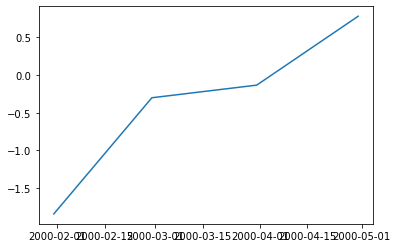

In [76]:
ts = pd.Series(np.random.randn(4),
               index=pd.date_range('2000-01-01', periods=4, freq='M'))
plt.plot(ts)
print(ts)

2000-01-31         NaN
2000-02-29         NaN
2000-03-31   -1.840359
2000-04-30   -0.301404
Freq: M, dtype: float64


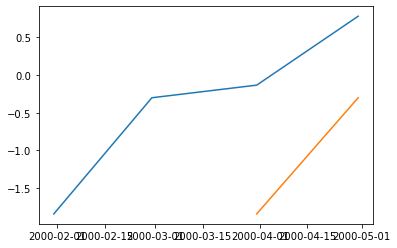

In [77]:
ts.shift(2) # сдвиг на 2 периода вперед
print(ts.shift(2))
plt.plot(ts)
plt.plot(ts.shift(2))

In [78]:
ts.shift(-2) # сдвиг на 2 периода назад

2000-01-31   -0.134273
2000-02-29    0.778518
2000-03-31         NaN
2000-04-30         NaN
Freq: M, dtype: float64

НО! Такой "фокус" не пройдет, если у вас индекс состоит не из ```PeriodObject```, а временных меток (```TimeStamp```).

In [79]:
rng = pd.date_range('2000-01-01', periods=3, freq='M')
ts = pd.Series(np.random.randn(3), index=rng)
ts.index

DatetimeIndex(['2000-01-31', '2000-02-29', '2000-03-31'], dtype='datetime64[ns]', freq='M')

Преобразовать индекс из временных меток в периоды можно функцией ```to_period()```.

In [80]:
pts = ts.to_period()
pts.index

PeriodIndex(['2000-01', '2000-02', '2000-03'], dtype='period[M]', freq='M')

In [81]:
rng = pd.date_range('1/29/2000', periods=6, freq='D')
ts2 = pd.Series(np.random.randn(6), index=rng)
ts2


2000-01-29   -0.122290
2000-01-30    3.152069
2000-01-31   -0.356974
2000-02-01   -0.802432
2000-02-02   -1.548401
2000-02-03    0.115482
Freq: D, dtype: float64

In [82]:
pts2 = ts2.to_period('M')
pts2

2000-01   -0.122290
2000-01    3.152069
2000-01   -0.356974
2000-02   -0.802432
2000-02   -1.548401
2000-02    0.115482
Freq: M, dtype: float64

Обратное преобразование выполняется методом ```to_timestamp()```

In [83]:
pts2.to_timestamp(how='end')

2000-01-31 23:59:59.999999999   -0.122290
2000-01-31 23:59:59.999999999    3.152069
2000-01-31 23:59:59.999999999   -0.356974
2000-02-29 23:59:59.999999999   -0.802432
2000-02-29 23:59:59.999999999   -1.548401
2000-02-29 23:59:59.999999999    0.115482
dtype: float64

__ЗАДАНИЕ__: Загрузите данные с ежечасной статистикой веб-трафика ```data/web_traffic.tsv```. Увы, дата начала сбора статистики неизвестна, известно, что последний день - 10 ноября 2019 года. Задайте индекс в виде даты/времени.

In [92]:
web_traffic = pd.read_csv('data/web_traffic.tsv', sep='\t', header=None, names=['Day', 'ReqsPerHour'])
web_traffic.head()
web_traffic.shape[0]
ix = pd.date_range(end='2019-11-10', periods=web_traffic.shape[0], freq='H')

web_traffic.index = ix
web_traffic

,Day,ReqsPerHour
2019-10-10 02:00:00,1,2272.0
2019-10-10 03:00:00,2,NaN
2019-10-10 04:00:00,3,1386.0
2019-10-10 05:00:00,4,1365.0
2019-10-10 06:00:00,5,1488.0
...,...,...
2019-11-09 20:00:00,739,4970.0
2019-11-09 21:00:00,740,4813.0
2019-11-09 22:00:00,741,5392.0
2019-11-09 23:00:00,742,5906.0


Как "вытащить" периоды из загруженного датасета:

In [93]:
data = pd.read_csv('data/macrodata.csv')
data.head(5)

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [100]:
data.year
data.quarter

1959Q1    1.0
1959Q2    2.0
1959Q3    3.0
1959Q4    4.0
1960Q1    1.0
         ... 
2008Q3    3.0
2008Q4    4.0
2009Q1    1.0
2009Q2    2.0
2009Q3    3.0
Freq: Q-DEC, Name: quarter, Length: 203, dtype: float64

In [97]:
index = pd.PeriodIndex(year=data.year, quarter=data.quarter,
                       freq='Q-DEC')
index

PeriodIndex(['1959Q1', '1959Q2', '1959Q3', '1959Q4', '1960Q1', '1960Q2',
             '1960Q3', '1960Q4', '1961Q1', '1961Q2',
             ...
             '2007Q2', '2007Q3', '2007Q4', '2008Q1', '2008Q2', '2008Q3',
             '2008Q4', '2009Q1', '2009Q2', '2009Q3'],
            dtype='period[Q-DEC]', length=203, freq='Q-DEC')

<AxesSubplot:>

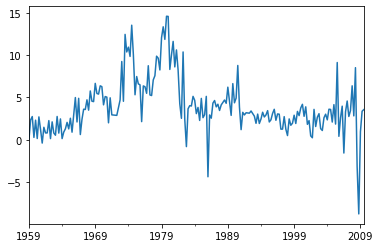

In [101]:
data.index = index
data.infl.plot()

__ЗАДАНИЕ__:

Загрузите датасет c данными по месячным температурам, постройте график. Сдвиньте график на год, на 2 года и на 5 лет, сравните. 

TypeError: get_axes() takes 1 positional argument but 2 were given

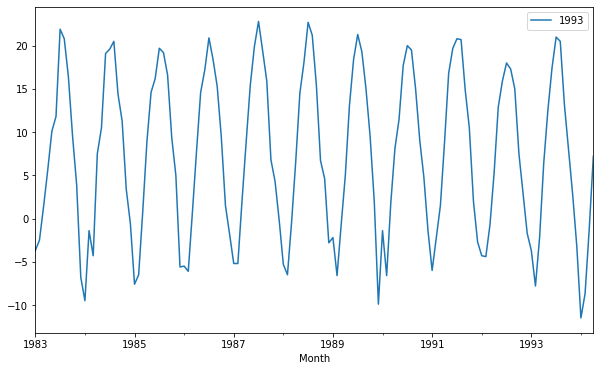

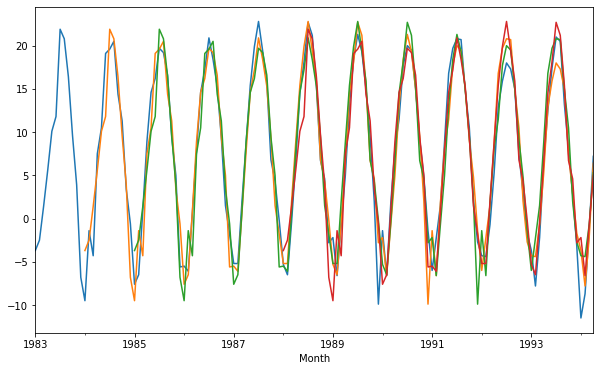

In [124]:
#plt.figure(figsize=(10,6))
temps = pd.read_csv('data/monthly-temperature-in-celsius-j.csv',
                      index_col=['Month'], parse_dates=['Month'], 
                      dayfirst=True)

temps_m = temps.to_period('M')
plt.rcParams['figure.figsize'] = (10.0, 6)
temps_m['temperature'].plot(label='1993')
plt.legend(loc='best')

fig = plt.figure()
shifts = [0, 1, 2, 5]
yfinish = np.max(temps_m.index).year
for shift in shifts:
    temps_m.shift(12 * shift)['temperature'].plot(label=f'{yfinish-shift}')

fig.get_axes([0]).set_xlim(f'{yfinish-1}-04', f'{yfinish}-04')

plt.legend(loc='best')

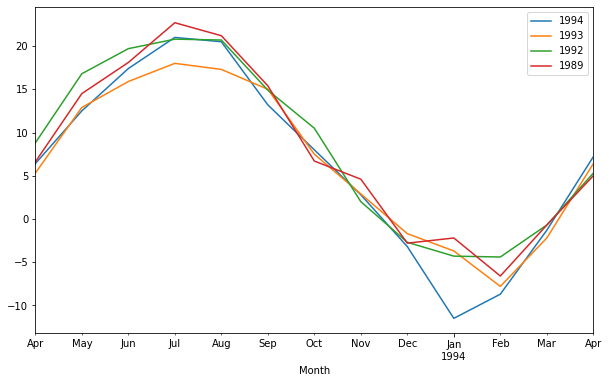

In [125]:
temps_m = temps.to_period('M')
plt.rcParams['figure.figsize'] = (10.0, 6)
fig = plt.figure()

shifts = [0, 1, 2, 5]
yfinish = np.max(temps_m.index).year
for shift in shifts:
    temps_m.shift(12*shift)['temperature'].plot(label=f"{yfinish-shift}")
fig.get_axes()[0].set_xlim(f"{yfinish-1}-04", f"{yfinish}-04")
plt.legend(loc="best")

### Ресемплинг


Повышающая дискретизация, upsampling

In [126]:
rng = pd.date_range('2020-01-01', periods=12, freq='T')
ts = pd.Series(np.arange(12), index=rng)
ts

2020-01-01 00:00:00     0
2020-01-01 00:01:00     1
2020-01-01 00:02:00     2
2020-01-01 00:03:00     3
2020-01-01 00:04:00     4
2020-01-01 00:05:00     5
2020-01-01 00:06:00     6
2020-01-01 00:07:00     7
2020-01-01 00:08:00     8
2020-01-01 00:09:00     9
2020-01-01 00:10:00    10
2020-01-01 00:11:00    11
Freq: T, dtype: int64

In [127]:
ts.resample('5min', closed='right').sum()

2019-12-31 23:55:00     0
2020-01-01 00:00:00    15
2020-01-01 00:05:00    40
2020-01-01 00:10:00    11
Freq: 5T, dtype: int64

Понижающая дискретизация, downsampling

In [128]:
frame = pd.DataFrame(np.random.randn(2, 4),
                     index=pd.date_range('1/1/2000', periods=2,
                                         freq='W-WED'),
                     columns=['Colorado', 'Texas', 'New York', 'Ohio'])
frame

,Colorado,Texas,New York,Ohio
2000-01-05,-0.206592,0.461954,-0.346332,-1.763851
2000-01-12,-0.020335,2.004598,-0.092004,-1.193422


In [129]:
df_daily = frame.resample('D').asfreq()
df_daily

,Colorado,Texas,New York,Ohio
2000-01-05,-0.206592,0.461954,-0.346332,-1.763851
2000-01-06,NaN,NaN,NaN,NaN
2000-01-07,NaN,NaN,NaN,NaN
2000-01-08,NaN,NaN,NaN,NaN
2000-01-09,NaN,NaN,NaN,NaN
2000-01-10,NaN,NaN,NaN,NaN
2000-01-11,NaN,NaN,NaN,NaN
2000-01-12,-0.020335,2.004598,-0.092004,-1.193422


In [130]:
frame.resample('D').ffill()

,Colorado,Texas,New York,Ohio
2000-01-05,-0.206592,0.461954,-0.346332,-1.763851
2000-01-06,-0.206592,0.461954,-0.346332,-1.763851
2000-01-07,-0.206592,0.461954,-0.346332,-1.763851
2000-01-08,-0.206592,0.461954,-0.346332,-1.763851
2000-01-09,-0.206592,0.461954,-0.346332,-1.763851
2000-01-10,-0.206592,0.461954,-0.346332,-1.763851
2000-01-11,-0.206592,0.461954,-0.346332,-1.763851
2000-01-12,-0.020335,2.004598,-0.092004,-1.193422


<AxesSubplot:>

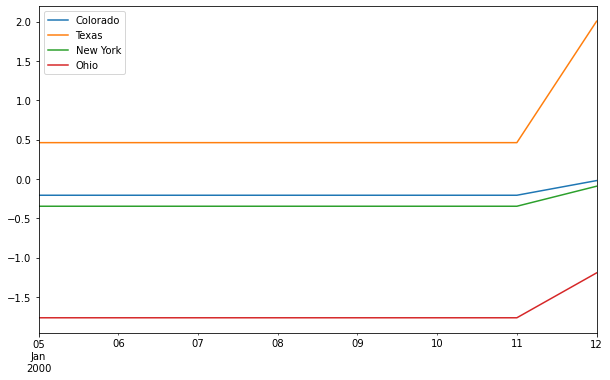

In [131]:
frame.resample('D').ffill().plot()

__ЗАДАНИЕ__: Для температурного датасета проеобразуйте период в "весна"-"лето"-"осень"-"зима" и постройте график. Сделайте сдвиги.

<AxesSubplot:xlabel='Month'>

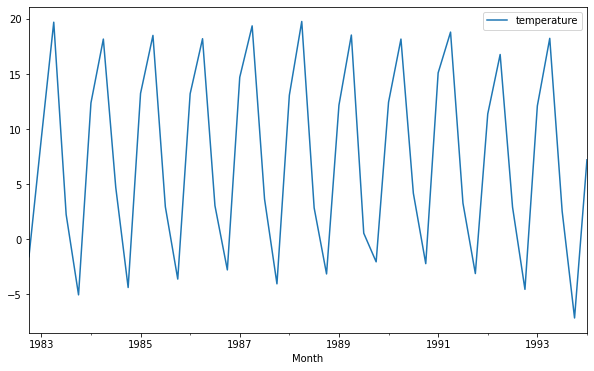

In [152]:
temperatures = pd.read_csv('data/monthly-temperature-in-celsius-j.csv',
                      index_col=['Month'], parse_dates=['Month'], 
                      dayfirst=True)

temperatures.resample('QS-DEC', closed='right').mean().plot()



#temperatures.to_period('Q')
#temperatures

### Статистический анализ временных рядов

Пример "скользящего среднего".

<AxesSubplot:>

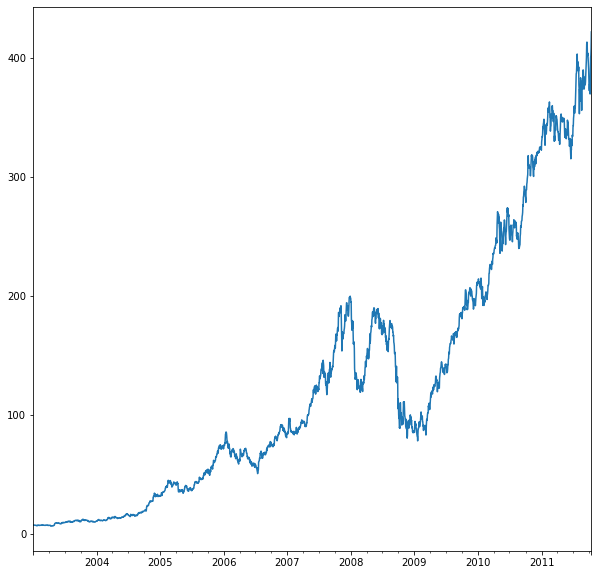

In [153]:
close_px_all = pd.read_csv('data/stock_px_2.csv', \
                           parse_dates=True, index_col=0)
close_px = close_px_all[['AAPL', 'MSFT', 'XOM']]
close_px = close_px.resample('B').ffill()
plt.rcParams['figure.figsize'] = (10.0, 10.0)
close_px['AAPL'].plot()

<AxesSubplot:>

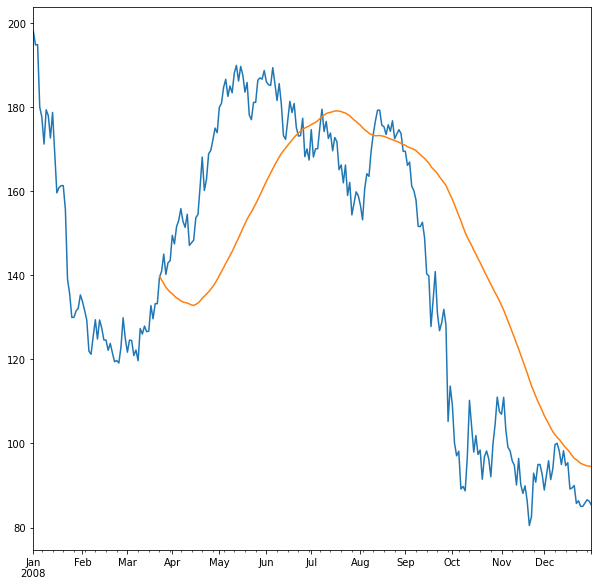

In [155]:
close_px = close_px['2008':'2008']

close_px.AAPL.plot()
#close_px.AAPL.rolling(50).mean().plot()
close_px.AAPL.rolling(60).mean().plot()
#close_px.AAPL.rolling(40).mean().plot()

#### STL-декомпозиция ряда

Для анализа ряда с ярко выраженной сезонностью используется STL-декомпозиция.

Она работает для двух моделей:

1) Аддитивная модель: используется, когда отколнения от тренда не сильно варьируется в определенных временных интервалах. Тогда наш показатель может быть представлен суммой, вычисляемой по формуле:\
        y(t) = уровень(t) + тренд(t) + сезонность(t) + шум(t)
    
2) Мультипликативная модель - используется, когда размах сезонности имеет выраженную зависимость от времени и тренда:\
        y(t) = уровень(t) * тренд(t) * сеознность(t) * шум(t)
        
Рассмотрим на примере датасета "продажи австралийского вина".

Text(0, 0.5, 'Wine sales')

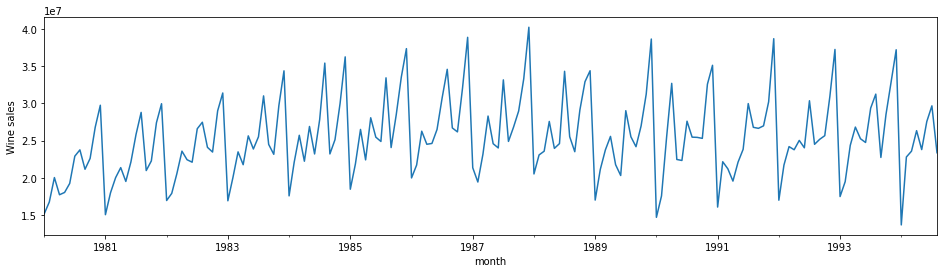

In [156]:
plt.figure(figsize=(16,4))
wine = pd.read_csv('data/monthly-australian-wine-sales.csv',
                   index_col=['month'], parse_dates=['month'], 
                   dayfirst=True)
wine.sales = wine.sales * 1000

wine.sales.plot()
plt.ylabel('Wine sales')

In [157]:
sm.tsa.seasonal_decompose?

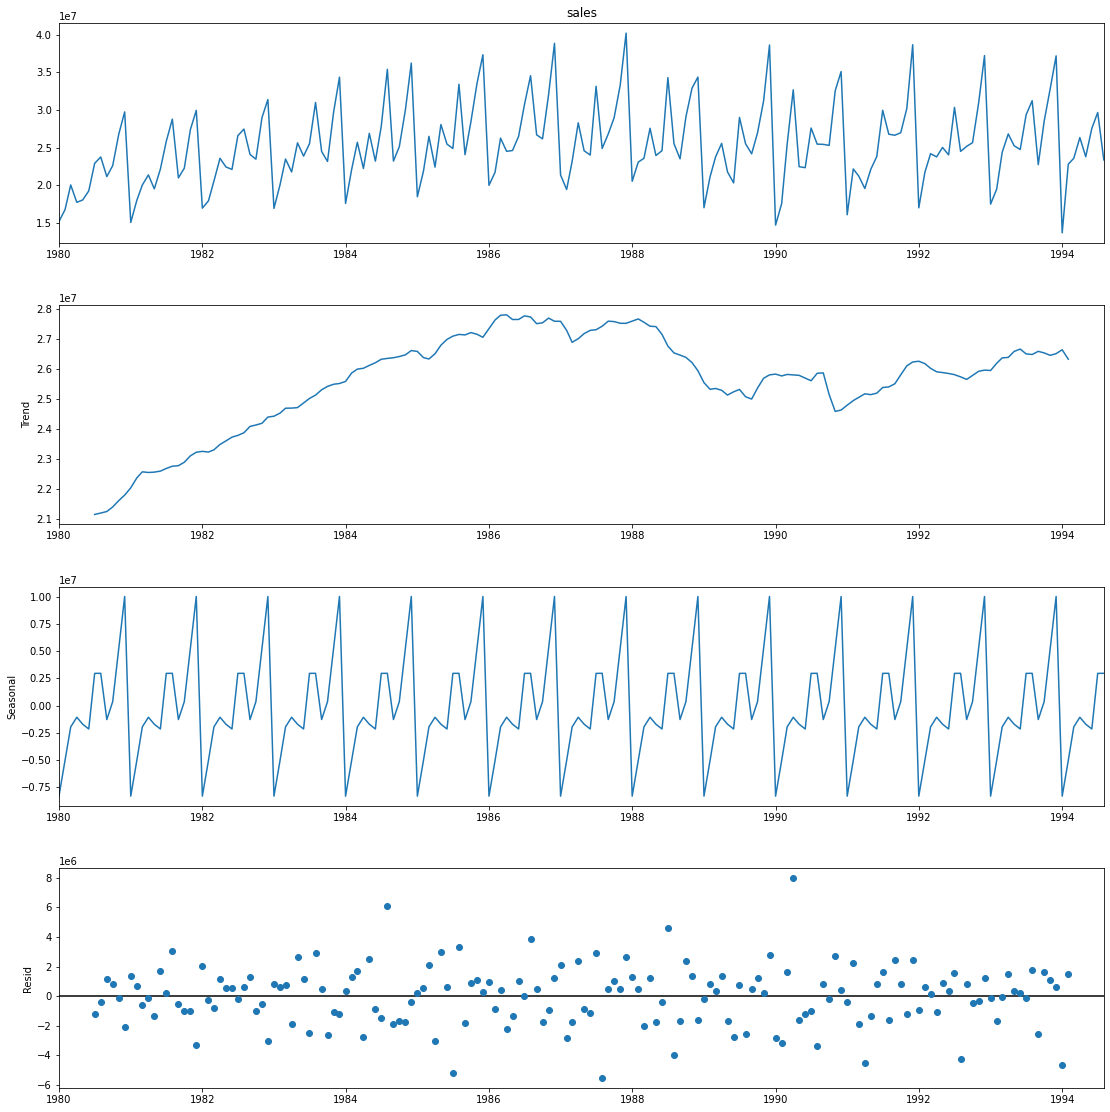

In [158]:
decomposition = sm.tsa.seasonal_decompose(wine.sales)
fig = decomposition.plot()
fig.set_figwidth(16)
fig.set_figheight(16)
plt.show()

Выведем отдельно тренд:

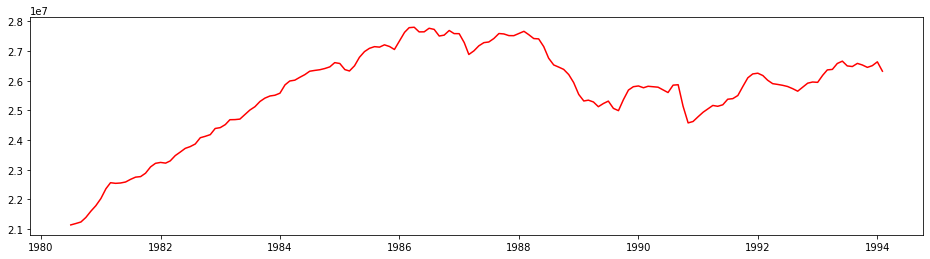

In [159]:
plt.figure(figsize=(16,4))
plt.plot(decomposition.trend.index, decomposition.trend, c='red')

__ЗАДАНИЕ__: выполните STL-декомпозицию для статистики по запросам веб-сервера - за последние 3 дня, последнюю неделю и предшествующую ей неделю. Данные собирались ежечасно, последний день сбора данных - 10 ноября 2019 года

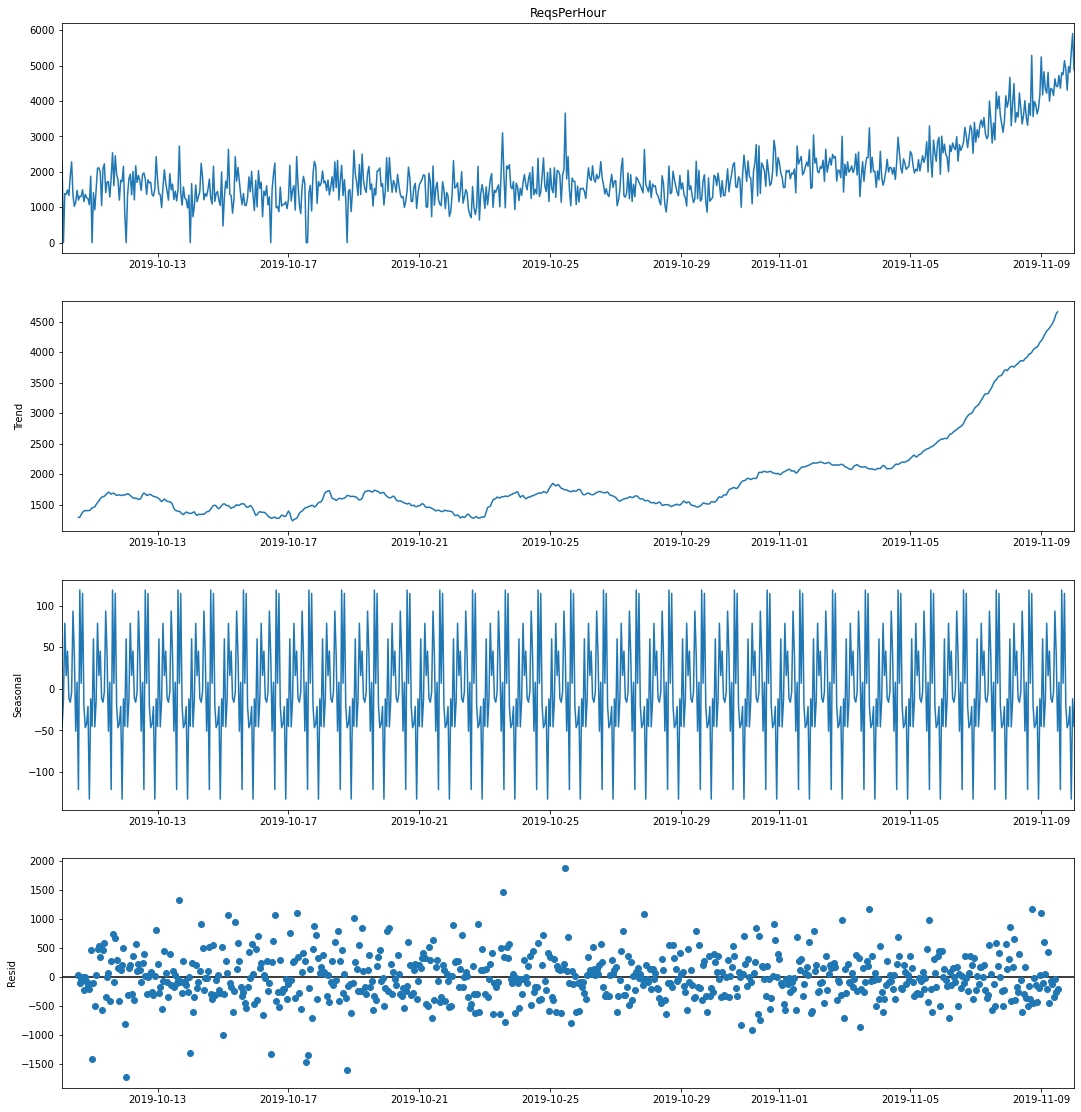

In [168]:
web_traffic = pd.read_csv('data/web_traffic.tsv', sep='\t', header=None, names=['Day', 'ReqsPerHour'])
web_traffic.head()

web_traffic.index = pd.date_range(end='2019-11-10', periods=web_traffic.shape[0], freq='H')

web_traffic.fillna(0, inplace=True)
web_traffic_d = sm.tsa.seasonal_decompose(web_traffic.ReqsPerHour)
fig = web_traffic_d.plot()
fig.set_figwidth(16)
fig.set_figheight(16)
plt.show()